In [1]:
from pykalman import KalmanFilter
import numpy as np
import pandas as pd
from scipy import poly1d
from datetime import datetime
import yfinance as yf

import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('seaborn-darkgrid')
plt.rcParams['figure.figsize'] = (10,7)

In [2]:
start_date='2017-02-01'
end_date='2023-12-31'
stocks=['META','ko']
df=yf.download(stocks,start=start_date,end=end_date)['Close']
df

[*********************100%***********************]  2 of 2 completed


,KO,META
Date,,
2017-01-31,41.570000,130.320007
2017-02-01,41.259998,133.229996
2017-02-02,41.400002,130.839996
2017-02-03,41.540001,130.979996
2017-02-06,41.560001,132.059998
...,...,...
2023-12-22,58.320000,353.390015
2023-12-26,58.560001,354.829987
2023-12-27,58.709999,357.829987


In [3]:
stock_1 = df['KO']
stock_2 = df['META']
df['ratio'] = df['KO']/ df['META']
ratio =stock_1/stock_2
df.head()

,KO,META,ratio
Date,,,
2017-01-31,41.570000,130.320007,0.318984
2017-02-01,41.259998,133.229996,0.309690
2017-02-02,41.400002,130.839996,0.316417
2017-02-03,41.540001,130.979996,0.317148
2017-02-06,41.560001,132.059998,0.314705


Text(0, 0.5, 'Value')

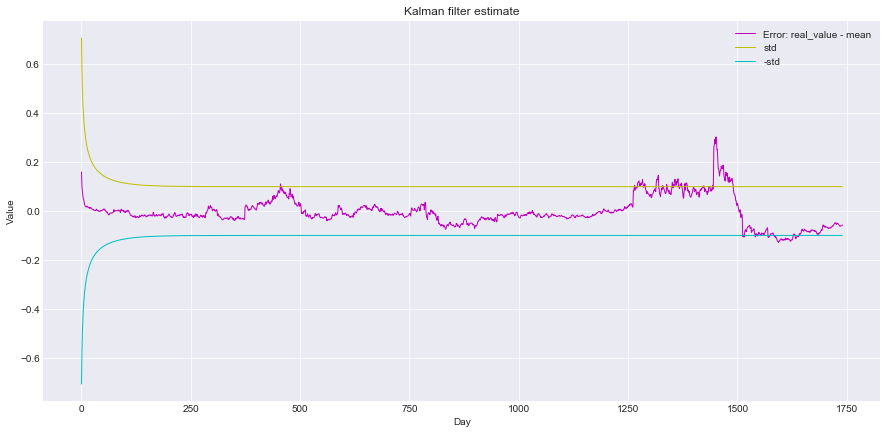

In [4]:
kf = KalmanFilter(transition_matrices = [1],
              observation_matrices = [1],
              initial_state_mean = 0,
              initial_state_covariance = 1,
              observation_covariance=1,
              transition_covariance=.0001)

mean, cov = kf.filter(ratio.values)
mean, std = mean.squeeze(), np.std(cov.squeeze())

plt.figure(figsize=(15,7))
plt.plot(ratio.values - mean, 'm', lw=1)
plt.plot(np.sqrt(cov.squeeze()), 'y', lw=1)
plt.plot(-np.sqrt(cov.squeeze()), 'c', lw=1)
plt.title('Kalman filter estimate')
plt.legend(['Error: real_value - mean', 'std', '-std'])
plt.xlabel('Day')
plt.ylabel('Value')


In [5]:
# Use the observed values of the price to get a rolling mean and z_score
mean, cov =  kf.filter(ratio.values)
df['mean'] = mean.squeeze()
df['cov'] = cov.squeeze()
df['std'] = np.sqrt(df['cov'])
df = df.dropna()
df

,KO,META,ratio,mean,cov,std
Date,,,,,,
2017-01-31,41.570000,130.320007,0.318984,0.159492,0.500000,0.707107
2017-02-01,41.259998,133.229996,0.309690,0.209565,0.333378,0.577389
2017-02-02,41.400002,130.839996,0.316417,0.236286,0.250081,0.500081
2017-02-03,41.540001,130.979996,0.317148,0.252468,0.200116,0.447343
2017-02-06,41.560001,132.059998,0.314705,0.262850,0.166817,0.408432
...,...,...,...,...,...,...
2023-12-22,58.320000,353.390015,0.165030,0.225583,0.009950,0.099750
2023-12-26,58.560001,354.829987,0.165037,0.224980,0.009950,0.099750
2023-12-27,58.709999,357.829987,0.164072,0.224374,0.009950,0.099750


In [6]:
df['ma'] = df['ratio'].rolling(5).mean()
df['z_score'] = (df['ma'] - df['mean'])/df['std']
df

,KO,META,ratio,mean,cov,std,ma,z_score
Date,,,,,,,,
2017-01-31,41.570000,130.320007,0.318984,0.159492,0.500000,0.707107,NaN,NaN
2017-02-01,41.259998,133.229996,0.309690,0.209565,0.333378,0.577389,NaN,NaN
2017-02-02,41.400002,130.839996,0.316417,0.236286,0.250081,0.500081,NaN,NaN
2017-02-03,41.540001,130.979996,0.317148,0.252468,0.200116,0.447343,NaN,NaN
2017-02-06,41.560001,132.059998,0.314705,0.262850,0.166817,0.408432,0.315389,0.128635
...,...,...,...,...,...,...,...,...
2023-12-22,58.320000,353.390015,0.165030,0.225583,0.009950,0.099750,0.166583,-0.591473
2023-12-26,58.560001,354.829987,0.165037,0.224980,0.009950,0.099750,0.165338,-0.597914
2023-12-27,58.709999,357.829987,0.164072,0.224374,0.009950,0.099750,0.164570,-0.599539


In [7]:
# Initialise positions as zero
df['position_1'] = np.nan
df['position_2'] = np.nan
df

,KO,META,ratio,mean,cov,std,ma,z_score,position_1,position_2
Date,,,,,,,,,,
2017-01-31,41.570000,130.320007,0.318984,0.159492,0.500000,0.707107,NaN,NaN,NaN,NaN
2017-02-01,41.259998,133.229996,0.309690,0.209565,0.333378,0.577389,NaN,NaN,NaN,NaN
2017-02-02,41.400002,130.839996,0.316417,0.236286,0.250081,0.500081,NaN,NaN,NaN,NaN
2017-02-03,41.540001,130.979996,0.317148,0.252468,0.200116,0.447343,NaN,NaN,NaN,NaN
2017-02-06,41.560001,132.059998,0.314705,0.262850,0.166817,0.408432,0.315389,0.128635,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...
2023-12-22,58.320000,353.390015,0.165030,0.225583,0.009950,0.099750,0.166583,-0.591473,NaN,NaN
2023-12-26,58.560001,354.829987,0.165037,0.224980,0.009950,0.099750,0.165338,-0.597914,NaN,NaN
2023-12-27,58.709999,357.829987,0.164072,0.224374,0.009950,0.099750,0.164570,-0.599539,NaN,NaN


In [8]:
for i in range (df.shape[0]):
  if df['z_score'].iloc[i] < -1:
    df['position_1'].iloc[i] = 1
    df['position_2'].iloc[i] = -1#round(df['ratio'].iloc[i],0)
  if df['z_score'].iloc[i] > 1:
    df['position_1'].iloc[i] = -1
    df['position_2'].iloc[i] = 1#round(df['ratio'].iloc[i],0)
  if (abs(df['z_score'].iloc[i]) < 1) & (abs(df['z_score'].iloc[i]) > 0):
    df['position_1'].iloc[i] = 0
    df['position_2'].iloc[i] = 0

In [9]:
df[df['position_1']==0]

,KO,META,ratio,mean,cov,std,ma,z_score,position_1,position_2
Date,,,,,,,,,,
2017-02-06,41.560001,132.059998,0.314705,0.262850,0.166817,0.408432,0.315389,0.128635,0.0,0.0
2017-02-07,41.900002,131.839996,0.317809,0.270712,0.143041,0.378207,0.315154,0.117508,0.0,0.0
2017-02-08,42.020000,134.199997,0.313115,0.276021,0.125217,0.353860,0.315839,0.112523,0.0,0.0
2017-02-09,41.250000,134.139999,0.307515,0.279528,0.111362,0.333709,0.314058,0.103473,0.0,0.0
2017-02-10,40.580002,134.190002,0.302407,0.281823,0.100284,0.316676,0.311110,0.092484,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...
2023-12-22,58.320000,353.390015,0.165030,0.225583,0.009950,0.099750,0.166583,-0.591473,0.0,0.0
2023-12-26,58.560001,354.829987,0.165037,0.224980,0.009950,0.099750,0.165338,-0.597914,0.0,0.0
2023-12-27,58.709999,357.829987,0.164072,0.224374,0.009950,0.099750,0.164570,-0.599539,0.0,0.0


In [10]:
# Calculate returns
df['returns'] = ((df['KO']-df['KO'].shift(1))/df['KO'].shift(1))*df['position_1'].shift(1)+ ((df['META']-df['META'].shift(1))/df['META'].shift(1))*df['position_2'].shift(1)
df['returns'].sum()

0.5095340129686039

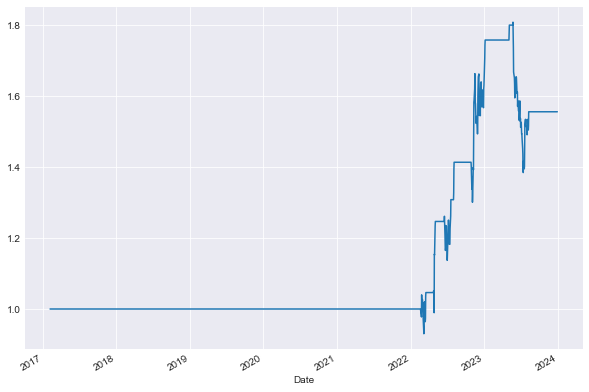

In [11]:
(1+df['returns']).cumprod().plot()

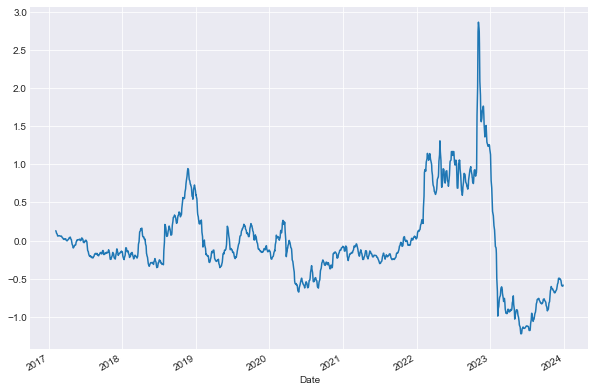

In [12]:
df['z_score'].plot()